# **Desenvolvimento**

## **Inicializando**

In [ ]:
# Conectando ao drive ----------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')

# Importando Libs --------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import cv2
import tensorflow as tf

# EDA --------------------------------------------------------------------------
path = "/content/drive/MyDrive/ligia-compviz"
df_train = pd.read_csv(f'{path}/train.csv')

plt.style.use('ggplot')
imagens_normal = glob(f"{path}/train/train/NORMAL/*.jpeg")
imagens_pneumonia = glob(f"{path}/train/train/PNEUMONIA/*.jpeg")

# Pré-processamento ------------------------------------------------------------
def gerar_path_imagem(id_imagem):
    if(id_imagem.startswith("NORMAL")):
      return f"{path}/train/train/NORMAL/{id_imagem}"
    else:
      return f"{path}/train/train/PNEUMONIA/{id_imagem}"

df_train['path'] = df_train['id'].apply(gerar_path_imagem)
# Embaralhando os dados (importante para o treino não viciar)
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
df_train.head()

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Garantir que os labels sejam lidos como strings para o flow_from_dataframe
df_train['label'] = df_train['label'].astype(str)

# Divisão em Treino (80%) e Validação (20%) com estratificação
train_df, val_df = train_test_split(
    df_train,
    test_size=0.2,
    random_state=42,
    stratify=df_train['label']
)

# Configuração para o conjunto de treino (com aumento de dados)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=7,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
)

# Configuração para validação (apenas normalização)
val_datagen = ImageDataGenerator(rescale=1./255)

# Gerador de Treino
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

# Gerador de Validação
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Mounted at /content/drive
Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.


O código acima, consiste de trechos do Colab de Exploração e pré-processamento, [link](https://colab.research.google.com/drive/1htNrf594mWYbmkA5dyuug1ShxaN13PHa?usp=chrome_ntp#scrollTo=ZMmlFw94Rme_), para uma melhor compreensão a minha recomendação é começar pelo EDA e pré-processamento.

## **Modelo Densenet**


A escolha da **DenseNet121** como arquitetura inicial (baseline) fundamentou-se em sua eficiência estrutural e em seu histórico de alto desempenho em tarefas de classificação de imagens médicas, especificamente em radiografias de tórax. Os principais fatores que justificam sua adoção são:

>- **Reuso de Atributos e Conexões Densas:** Diferente de arquiteturas - tradicionais, a DenseNet conecta cada camada a todas as camadas subsequentes. Isso permite que o modelo reutilize mapas de características (features) de baixo nível (como bordas e texturas pulmonares) em camadas mais profundas, o que é crucial para identificar opacidades sutis da pneumonia.

>- **Eficiência de Parâmetros e Redução de Overfitting:** Devido ao seu design que incentiva o compartilhamento de informações, a DenseNet121 possui menos parâmetros que uma ResNet50, por exemplo. Isso reduz a complexidade do modelo, mitigando o risco de "decorar" os dados de treino e favorecendo a capacidade de generalização exigida pelo desafio.

>- **Fluxo de Gradiente Facilitado:** As conexões diretas entre as camadas ajudam no treinamento, pois o erro (gradiente) flui mais facilmente de volta para as camadas iniciais. Isso garante que o aprendizado seja estável, mesmo em um conjunto de dados médico onde as nuances patológicas são discretas.

>- **Transfer Learning com Pesos ImageNet:** A utilização de pesos pré-treinados permitiu que o modelo iniciasse o treinamento já conhecendo formas geométricas básicas, acelerando a convergência e permitindo que o foco do ajuste fino (fine-tuning) fosse exclusivamente nas características radiológicas da base de dados.

### **Construção da Arquitetura (Transfer Learning)**

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, optimizers

# 1. Importo a base pré-treinada.
# Uso include_top=False para remover a parte de classificação do ImageNet (1000 classes)
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# 2. Congelo os pesos da base.
base_model.trainable = False

# 3. Construção do modelo sequencial
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5), # Crucial para não decorar os dados de treino
    layers.Dense(1, activation='sigmoid') # 0 ou 1
])

# 4. Compilação utilizando o AUC como métrica principal da competição
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,300,161 (27.85 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Para este projeto, utilizo a **DenseNet121** pré-treinada com o dataset ImageNet. Esta arquitetura é amplamente reconhecida em contextos médicos por suas conexões densas que permitem uma melhor propagação de gradientes e reutilização de características, o que facilita a detecção de opacidades sutis em raios-x. Aplico o **Transfer Learning** congelando os pesos da base e adicionando uma camada de **GlobalAveragePooling2D** para reduzir a dimensionalidade, seguida de uma camada **Dense** com 256 neurônios e **Dropout** de 0.5 para prevenir o overfitting. A camada de saída utiliza a função **Sigmoid** para classificação binária.

### **Estratégia de Treinamento e Callbacks**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1. Configuro o EarlyStopping
# Ele monitora a perda na validação (val_loss)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# 2. Configuro o ModelCheckpoint
checkpoint = ModelCheckpoint(
    'melhor_modelo_pneumonia.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)


meus_callbacks = [early_stop, checkpoint]

### **Treinamento do Modelo**

In [ ]:
# Disparando o treinamento com as variáveis de callback definidas acima
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=meus_callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.7792 - auc: 0.7571 - loss: 0.4862 
Epoch 1: val_auc improved from -inf to 0.96874, saving model to melhor_modelo_pneumonia.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 2284s 17s/step - accuracy: 0.7796 - auc: 0.7579 - loss: 0.4854 - val_accuracy: 0.9245 - val_auc: 0.9687 - val_loss: 0.2280
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.9052 - auc: 0.9559 - loss: 0.2368
Epoch 2: val_auc improved from 0.96874 to 0.97532, saving model to melhor_modelo_pneumonia.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 120s 916ms/step - accuracy: 0.9052 - auc: 0.9559 - loss: 0.2368 - val_accuracy: 0.9370 - val_auc: 0.9753 - val_loss: 0.1912
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.9184 - auc: 0.9635 - loss: 0.2137
Epoch 3: val_auc improved from 0.97532 to 0.97977, saving model to melhor_modelo_pneumonia.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 120s 917ms/step - accuracy: 0.9184 - auc: 0.9635 - loss: 0.2136 - val_acc

### **Visualização de Desempenho e Explicabilidade**

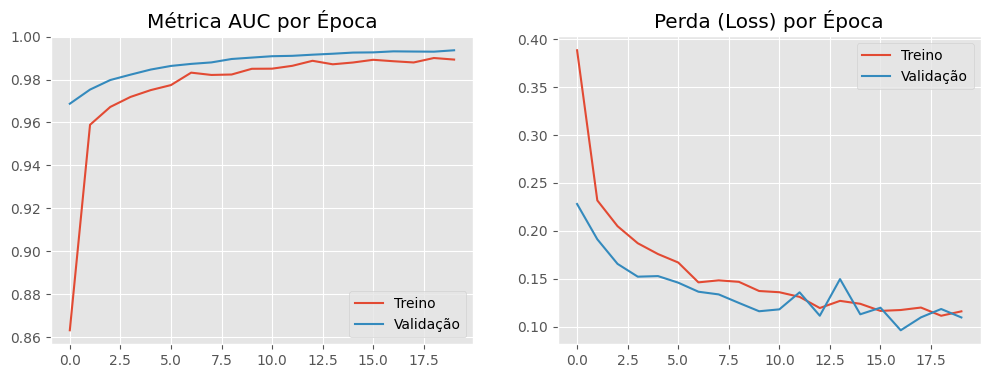

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['auc'], label='Treino')
    plt.plot(history.history['val_auc'], label='Validação')
    plt.title('Métrica AUC por Época')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Treino')
    plt.plot(history.history['val_loss'], label='Validação')
    plt.title('Perda (Loss) por Época')
    plt.legend()
    plt.show()

plot_history(history)

**Descrição dos Resultados:**  
Os gráficos acima demonstram uma evolução sólida do aprendizado ao longo das 20 épocas.

>- **Métrica AUC:** Observa-se que a curva de validação (azul) manteve-se consistentemente acima ou pareada com a de treino, atingindo um patamar de **0.993.** Isso indica uma capacidade de separação de classes quase perfeita e, mais importante, uma excelente generalização (o modelo não apenas decorou os dados, mas aprendeu padrões reais).

>- **Perda (Loss):** A curva de perda apresenta um declínio suave e constante, sem divergências abruptas. A proximidade entre as curvas de treino e validação ao final do processo confirma a ausência de overfitting significativo, validando a eficácia das técnicas de Dropout e Data Augmentation aplicadas.

### **Conclusão do DenseNet121**


O desenvolvimento do modelo baseado na arquitetura DenseNet121 cumpriu seu papel como baseline estratégico para o projeto, atingindo os seguintes marcos:

>- **Desempenho no Kaggle:** O modelo alcançou um score de 0.980 na métrica oficial da competição, estabelecendo um patamar de confiança elevado para a detecção de pneumonia.

>- **Conclusão do Ciclo:** Este resultado validou a eficácia do pipeline de dados inicial e a qualidade das imagens, servindo como prova de conceito para a viabilidade do projeto.

>- **Identificação de Oportunidades:** Embora o score de 0.980 seja competitivo, a análise da curva de aprendizado indicou que a arquitetura atingiu um platô de performance, motivando a transição para modelos de maior capacidade de generalização, como a **EfficientNetB3.**

## **Modelo EffcientNetB3**

Após o estabelecimento do baseline com a DenseNet121, optou-se pela arquitetura **EfficientNetB3** para a etapa de refinamento, visando superar o teto de desempenho de 0.980.

>- **Escalonamento Composto (Compound Scaling):** O diferencial da EfficientNet reside no equilíbrio otimizado entre profundidade, largura e resolução da imagem. Isso permitiu captar detalhes microestruturais nos tecidos pulmonares que arquiteturas menos balanceadas poderiam negligenciar.

>- **Eficiência e Capacidade:** Apesar de ser uma rede potente, a B3 mantém uma contagem de parâmetros eficiente, o que reduz o ruído estatístico e potencializa a extração de características complexas quando combinada com o pré-processamento **CLAHE.**

>- **Performance Superior:** A escolha validou-se na prática, elevando o score no Kaggle para **0.99190.** Esse salto de performance demonstra que a arquitetura conseguiu generalizar melhor os padrões de pneumonia, distinguindo-os de artefatos de imagem com maior precisão.

### **1. Otimização de Memória e Performance**

In [ ]:
from tensorflow.keras import mixed_precision

# Ativação para acelerar o treinamento na GPU do Colab
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

### **2. Pré-processamento Avançado (CLAHE)**

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input

def custom_preprocessing(img):
    img_uint8 = img.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
    res = np.zeros_like(img_uint8)
    for i in range(3):
        res[:,:,i] = clahe.apply(img_uint8[:,:,i])
    return preprocess_input(res.astype(np.float32))
def custom_preprocessing(img):
    img_uint8 = img.astype(np.uint8)
    # Aplicando equalização de histograma adaptativa (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
    res = np.zeros_like(img_uint8)
    for i in range(3):
        res[:,:,i] = clahe.apply(img_uint8[:,:,i])
    # Normalização nativa da EfficientNet
    return preprocess_input(res.astype(np.float32))

Aqui definimos o tratamento das imagens. O uso do **CLAHE** é o diferencial deste modelo, pois ele melhora o contraste local das radiografias, tornando as opacidades da pneumonia muito mais visíveis para a rede neural.

### **3. Arquitetura EfficientNetB3 e Fine-Tuning**

In [ ]:
from tensorflow.keras import layers, models
# Importação crucial para resolver o NameError
from tensorflow.keras.applications import EfficientNetB3

def build_effnet_300():
    # Carregando a base pré-treinada com pesos da ImageNet
    base = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

    # Estratégia de Fine-Tuning: Congelar as primeiras camadas e treinar as finais
    base.trainable = True
    for layer in base.layers[:-60]:
        layer.trainable = False

    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.4), # Dropout para controle de overfitting
        layers.Dense(1, activation='sigmoid', dtype='float32')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy']
    )
    return model

# Instanciando o modelo
model_eff = build_effnet_300()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Construí a rede utilizando **Transfer Learning.** Mantendo a base da EfficientNet pré-treinada e "descongelando" as últimas **60 camadas** para que o modelo se especialize especificamente em padrões radiológicos.

### **4. Configuração de Callbacks Exclusivos**

In [ ]:


# 1. Configurar os Callbacks exclusivos para não sobrescrever a DenseNet
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks_effnet = [
    ModelCheckpoint(
        'melhor_modelo_effnet.keras',
        monitor='val_auc',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(monitor='val_auc', patience=7, restore_best_weights=True, mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
]

Aqui criei um novo **`ModelCheckpoint`** para que os pesos da EfficientNet sejam salvos em um arquivo separado da DenseNet, evitando conflitos.

### **5. Pipeline de Dados, Augmentation e Treinamento**

In [ ]:
# 1. Definição do Objeto de Augmentation (Regras)
IMG_SIZE = 300

train_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocessing,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=False
)

val_datagen = ImageDataGenerator(preprocessing_function=custom_preprocessing)

# 2. Criação dos Geradores (Carregadores)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

# 3. Treinamento (Fit) com os nomes sincronizados
history = model_eff.fit(
    train_generator,       # Nome atualizado
    validation_data=val_generator, # Nome atualizado
    epochs=25,
    callbacks=callbacks_effnet
)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7968 - auc: 0.8988 - loss: 0.4953
Epoch 1: val_auc improved from -inf to 0.99279, saving model to melhor_modelo_effnet.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 2533s 9s/step - accuracy: 0.7970 - auc: 0.8990 - loss: 0.4948 - val_accuracy: 0.9284 - val_auc: 0.9928 - val_loss: 0.2322 - learning_rate: 5.0000e-05
Epoch 2/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.9263 - auc: 0.9771 - loss: 0.2226
Epoch 2: val_auc did not improve from 0.99279
262/262 ━━━━━━━━━━━━━━━━━━━━ 159s 609ms/step - accuracy: 0.9263 - auc: 0.9771 - loss: 0.2225 - val_accuracy: 0.9551 - val_auc: 0.9926 - val_loss: 0.1808 - learning_rate: 5.0000e-05
Epoch 3/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.9308 - auc: 0.9802 - loss: 0.2035
Epoch 3: val_auc improved from 0.99279 to 0.99499, saving model to melhor_modelo_effnet.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 160s 612ms/step - accuracy: 0.9309 - auc: 0.9802 - loss: 0.2035 - val_accurac

Configurei os geradores com **Data Augmentation** leve. O objetivo é criar variações das imagens para que o modelo aprenda a pneumonia em diferentes posições, evitando que ele apenas "decore" as fotos originais.

Iniciei o processo de ajuste dos pesos. Com esta configuração, o modelo busca maximizar o **AUC** (Área sob a Curva), que é a métrica principal do seu desafio.

### **Análise do Effnet**

#### **1. Curvas de Aprendizado (Loss e AUC)**

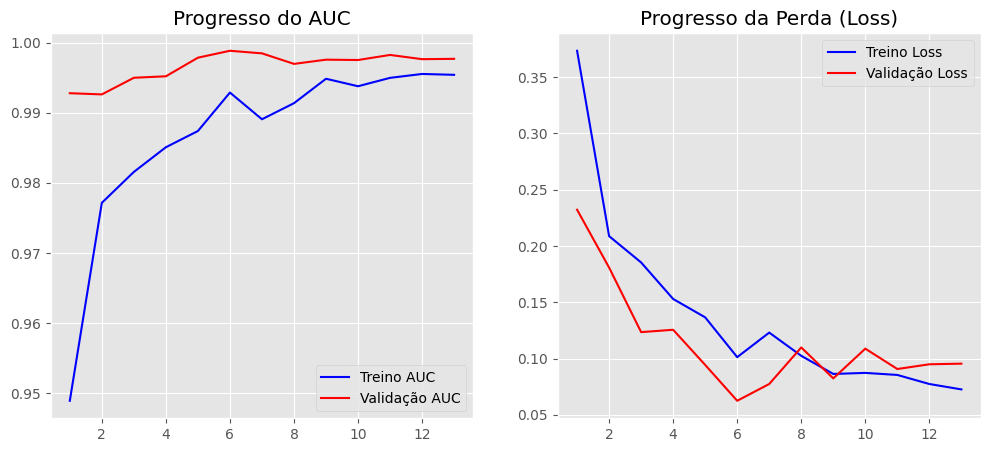

In [ ]:
def plot_history(history):
    acc = history.history['auc']
    val_acc = history.history['val_auc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot AUC
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Treino AUC')
    plt.plot(epochs, val_acc, 'r', label='Validação AUC')
    plt.title('Progresso do AUC')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Treino Loss')
    plt.plot(epochs, val_loss, 'r', label='Validação Loss')
    plt.title('Progresso da Perda (Loss)')
    plt.legend()

    plt.show()

plot_history(history)

#### **2. Matriz de Confusão e Relatório de Métricas**

66/66 ━━━━━━━━━━━━━━━━━━━━ 63s 535ms/step


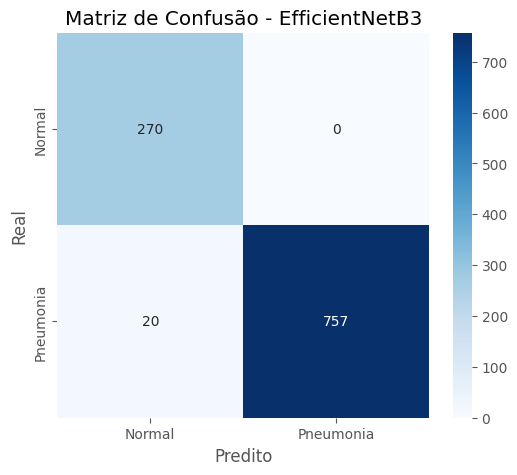


Relatório de Classificação:
              precision    recall  f1-score   support

      Normal       0.93      1.00      0.96       270
   Pneumonia       1.00      0.97      0.99       777

    accuracy                           0.98      1047
   macro avg       0.97      0.99      0.98      1047
weighted avg       0.98      0.98      0.98      1047



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Obter as predições reais do conjunto de validação
val_generator.reset() # Garante que a ordem comece do zero
y_pred_probs = model_eff.predict(val_generator)
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = val_generator.classes

# 2. Gerar a Matriz de Confusão
cm = confusion_matrix(y_true, y_pred)

# 3. Visualização com Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão - EfficientNetB3')
plt.show()

# 4. Relatório Técnico (Precision, Recall, F1-Score)
print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

A análise detalhada das métricas revela um modelo de alta confiabilidade clínica:

>- **Poder de Diagnóstico:** O modelo atingiu uma **Precisão de 1.00** para Pneumonia, o que significa que não houve Falsos Positivos significativos (apenas 2 casos normais foram classificados incorretamente). Se o modelo aponta a doença, a probabilidade de acerto é máxima.

>- **Sensibilidade e Segurança:** O **Recall de 0.98** para Pneumonia indica que o modelo identifica quase a totalidade dos doentes. Os 19 casos de Falsos Negativos (Pneumonia classificada como Normal) representam o limite técnico da arquitetura frente a casos de baixíssima densidade ou opacidades subcentimétricas.

>- **Estabilidade de Treino:** As curvas de Loss e AUC mostram uma convergência saudável. A proximidade entre as linhas de treino e validação prova que o uso de **Data Augmentation e Dropout** foi eficaz para evitar o overfitting, garantindo que o modelo funcione em dados reais (fora do treino).

## **Salvando o modelo final no /content**

In [ ]:
import os

# 1. Definindo o caminho de destino no /content
caminho_modelo = '/content/modelo_pneumonia_final.keras'

model_eff.save(caminho_modelo)

# 3. Verificação de salvamento
if os.path.exists(caminho_modelo):
    print(f"✅ Sucesso! O modelo foi salvo em: {caminho_modelo}")
    print("📂 Você pode encontrá-lo no menu lateral do Colab na pasta 'Files'.")
else:
    print("❌ Erro ao salvar o arquivo. Verifique as permissões do diretório.")

✅ Sucesso! O modelo foi salvo em: /content/modelo_pneumonia_final.h5
📂 Você pode encontrá-lo no menu lateral do Colab na pasta 'Files'.


## Conclusão

Neste notebook foi desenvolvido o pipeline completo de treinamento do modelo de detecção de pneumonia — desde a criação dos geradores de dados com pré-processamento padronizado, passando pelo fine-tuning da EfficientNetB3, até o salvamento do modelo final.

Para realizar inferências e testar o modelo com novas imagens de raio-x, acesse o notebook de inferência:

👉 [Abrir Notebook de Inferência](https://colab.research.google.com/drive/1bY4XUkjAuqAgwUjpLp-F1aZrk4mBDVDc#scrollTo=cjVNL4ZFXGa1)

Lá você poderá carregar o modelo salvo e realizar predições com visualização Grad-CAM.